# Εκπαίδευση Μοντέλου Ευθυγράμμισης Ομιλίας–Κειμένου

Σε αυτό το notebook εκπαιδεύουμε ένα **contrastive alignment model** που μαθαίνει να αντιστοιχίζει αναπαραστάσεις ομιλίας (speech embeddings) με αναπαραστάσεις κειμένου (text embeddings) στον ίδιο χώρο.

**Αρχιτεκτονική:**
- **Speech encoder**: Frozen Whisper-tiny — προ-υπολογισμένα hidden states `[B, T, 384]`
- **Text encoder**: Frozen multilingual-e5-small — προ-υπολογισμένα embeddings `[B, 384]`
- **Aligner**: Εκπαιδεύσιμος CNN με multi-kernel convolutions που μετατρέπει τα speech hidden states σε ένα κοινό embedding space
- **Συνάρτηση κόστους**: Symmetric InfoNCE (contrastive loss) με εκπαιδεύσιμη θερμοκρασία $\tau$

**Ροή δεδομένων:**
$$\text{speech\_hidden} \xrightarrow{\text{CNN Aligner}} \text{aligned} \xrightarrow{\text{mean pool}} \text{speech\_emb} \xrightarrow{\ell_2\text{-norm}} \hat{s}$$
$$\text{logits} = \frac{\hat{s} \cdot \hat{t}^\top}{\tau}, \quad \mathcal{L} = \frac{1}{2}\left[\text{CE}(\text{logits}, y) + \text{CE}(\text{logits}^\top, y)\right]$$

## 1. Εισαγωγή Βιβλιοθηκών

Εισάγουμε τις απαραίτητες βιβλιοθήκες:
- **PyTorch** (`torch`, `torch.nn`, `torch.nn.functional`): Για τον ορισμό και εκπαίδευση νευρωνικών δικτύων
- **HuggingFace Transformers**: Για πρόσβαση στα προ-εκπαιδευμένα μοντέλα
- **Εργαλεία επεξεργασίας κειμένου**: `re`, `string`, `unicodedata` για καθαρισμό μεταγραφών

In [1]:
import os
import torch
import torch.nn as nn, torch.nn.functional as F
from datasets import load_from_disk

import lightning as L
from torch.utils.data import Dataset, DataLoader

from models import mean_pooling, CnnAdapter, AlignmentModel
from preprocess import run as precompute

import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

/home/sted/.venvs/diplomatiki/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2. Φόρτωση Δεδομένων

Χρησιμοποιούμε το dataset **ddamianos/hparl** (Ελληνικά Κοινοβουλευτικά Πρακτικά) με προ-υπολογισμένα embeddings.

### 2.1 Προεπεξεργασία Κειμένου

Ορίζουμε τη συνάρτηση `preprocess_sentence` για τον καθαρισμό των μεταγραφών:
1. Αφαίρεση tokens `[UNK]`
2. Αφαίρεση σημείων στίξης
3. Κανονικοποίηση Unicode (NFKD)
4. Μετατροπή σε πεζά
5. Αφαίρεση πλεονάζοντων κενών

In [2]:
# Base directory for the dataset
base = "/mnt/h/"

# Path to precomputed dataset
PRECOMPUTED_PATH = f"{base}/hparl-preprocessed"

# HuggingFace caches
os.environ["HF_DATASETS_CACHE"] = f"{base}/datasets"
os.environ["HF_HOME"] = base
os.environ["TRANSFORMERS_CACHE"] = f"{base}/models"

### 2.2 Φόρτωση Προ-υπολογισμένων Embeddings

Φορτώνουμε τo dataset που παρήχθη από το `preprocess.py`. Αν δεν υπάρχει στον δίσκο, εκτελούμε αυτόματα την προεπεξεργασία μέσω `preprocess.run()`.

Περιέχει:

| Στήλη | Σχήμα | Περιγραφή |
|-------|-------|-----------|
| `pooled_speech_embeddings` | `[T, 384]` | Χρονικά pooled hidden states του Whisper encoder |
| `pooled_attn_masks` | `[T]` | Μάσκα προσοχής (1 = πραγματικό frame, 0 = padding) |
| `transcript_embeddings` | `[384]` | L2-κανονικοποιημένα E5 embeddings κειμένου |

Μετατρέπουμε σε format PyTorch tensors με `.with_format('torch')`.

Το `test` split κρατιέται **αποκλειστικά για τελική αξιολόγηση** (evaluation). Κατά την εκπαίδευση, χωρίζουμε το `train` split σε **80% train / 20% validation** για παρακολούθηση του validation loss.

In [3]:
# Load precomputed dataset (whisper hidden states + e5 text embeddings)
# If it doesn't exist on disk, run preprocessing first.
from pathlib import Path
from datasets import load_from_disk

if Path(PRECOMPUTED_PATH).exists():
    print(f"Loading precomputed dataset from {PRECOMPUTED_PATH}")
    ds = load_from_disk(PRECOMPUTED_PATH).with_format('torch')
else:
    print(f"Precomputed dataset not found at {PRECOMPUTED_PATH}, running preprocessing...")
    ds = precompute(base='/mnt/h', save_dir='hparl_precomputed').with_format('torch')
    print("Preprocessing complete.")

# Reserve test split for final evaluation only
test_ds = ds['test']

# Split train into 80% train / 20% validation
split = ds['train'].train_test_split(test_size=0.2, seed=42)
train_ds = split['train']
val_ds = split['test']

print(f"Train: {len(train_ds)}, Val: {len(val_ds)}, Test (held out): {len(test_ds)}")
print(f"Columns: {train_ds.column_names}")
print(f"Speech shape: {train_ds[0]['pooled_speech_embeddings'].shape}")
print(f"Mask shape:   {train_ds[0]['pooled_attn_masks'].shape}")
print(f"Text shape:   {train_ds[0]['transcript_embeddings'].shape}")

Loading precomputed dataset from /mnt/h//hparl-preprocessed
Train: 61072, Val: 15269, Test (held out): 8679
Columns: ['pooled_speech_embeddings', 'pooled_attn_masks', 'transcript_embeddings']
Speech shape: torch.Size([374, 384])
Mask shape:   torch.Size([374])
Text shape:   torch.Size([384])


## 3. Μοντέλα (από `models.py`)

Οι ορισμοί των μοντέλων βρίσκονται στο αρχείο `models.py` και εισάγονται στο cell 1.

Τα βασικά components:
1. **`mean_pooling`**: Mask-aware μέσος όρος πάνω στη χρονική διάσταση
2. **`CnnAdapter`**: CNN adapter με multi-kernel convolutions — μετατρέπει speech hidden states `[B, T, 384]` → `[B, T', 384]`
3. **`AlignmentModel`**: Δέχεται ένα adapter ως argument, προσθέτει mean pooling + L2 norm + symmetric InfoNCE loss

**Αρχιτεκτονική `CnnAdapter`:**
```
[B, T, 384] → transpose → [B, 384, T]
    → Conv1d(k=3) ⊕ Conv1d(k=5) ⊕ Conv1d(k=7) → [B, 768, T]
    → MaxPool1d → [B, 768, T/2]
    → LayerNorm → (repeat) → [B, 768, T/4]
    → Conv1d(1×1) → [B, 384, T/4]
    → transpose → [B, T/4, 384]
```

**Συνάρτηση κόστους InfoNCE:**

$$\mathcal{L} = \frac{1}{2}\left[\text{CE}\left(\frac{S \cdot T^\top}{\tau},\, y\right) + \text{CE}\left(\frac{T \cdot S^\top}{\tau},\, y\right)\right]$$

όπου $S, T \in \mathbb{R}^{B \times D}$ τα κανονικοποιημένα embeddings, $\tau = e^{\log\tau}$ η εκπαιδεύσιμη θερμοκρασία.

## 4. Pipeline Εκπαίδευσης — PyTorch Lightning

Χρησιμοποιούμε **PyTorch Lightning** για τη διαχείριση του training loop.

### 4.1 `PrecomputedDataset` & `collate_fn`

- **`PrecomputedDataset`**: Ελαφρύ `torch.Dataset` wrapper γύρω από ένα HuggingFace split. Μετατρέπει κάθε δείγμα σε `dict` με tensors `speech`, `mask`, `text`.
- **`collate_fn`**: Custom collator που κάνει **padding στη χρονική διάσταση** (τα speech embeddings μπορεί να έχουν διαφορετικό μήκος λόγω της μάσκας) και stack τα text embeddings.

In [4]:
class PrecomputedDataset(Dataset):
    """Thin wrapper around an HF split with precomputed embeddings."""

    def __init__(self, hf_split):
        self.ds = hf_split

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]
        return {
            'speech': item['pooled_speech_embeddings'].detach().clone() if isinstance(item['pooled_speech_embeddings'], torch.Tensor) else torch.tensor(item['pooled_speech_embeddings'], dtype=torch.float32),
            'mask':   item['pooled_attn_masks'].detach().clone() if isinstance(item['pooled_attn_masks'], torch.Tensor) else torch.tensor(item['pooled_attn_masks'], dtype=torch.long),
            'text':   item['transcript_embeddings'].detach().clone() if isinstance(item['transcript_embeddings'], torch.Tensor) else torch.tensor(item['transcript_embeddings'], dtype=torch.float32),
        }


def collate_fn(batch):
    """Pad speech/mask in time dimension, stack text embeddings."""
    speech_list = [b['speech'] for b in batch]
    mask_list   = [b['mask'] for b in batch]
    text_list   = [b['text'] for b in batch]

    max_T = max(s.shape[0] for s in speech_list)
    D = speech_list[0].shape[1]

    padded_speech = torch.zeros(len(batch), max_T, D)
    padded_mask   = torch.zeros(len(batch), max_T, dtype=torch.long)

    for i, (s, m) in enumerate(zip(speech_list, mask_list)):
        T = s.shape[0]
        padded_speech[i, :T] = s
        padded_mask[i, :T] = m

    return {
        'speech': padded_speech,
        'mask':   padded_mask,
        'text':   torch.stack(text_list),
    }

### 4.2 `AlignmentLitModule`

Lightning wrapper γύρω από το `AlignmentModel`. Δέχεται ένα **adapter** (π.χ. `CnnAdapter`) ως argument:
- **`training_step`** / **`validation_step`**: Forward pass + loss logging
- **`configure_optimizers`**: AdamW optimizer μόνο για τις παραμέτρους του adapter και τη θερμοκρασία $\log\tau$

In [5]:
class AlignmentLitModule(L.LightningModule):
    """Lightning wrapper around AlignmentModel (precomputed embeddings)."""

    def __init__(self, adapter: nn.Module, lr=1e-4, weight_decay=0.0, init_tau=0.07):
        super().__init__()
        self.save_hyperparameters(ignore=['adapter'])
        self.model = AlignmentModel(adapter=adapter, init_tau=init_tau)

    def forward(self, speech, mask, text):
        return self.model(speech, mask, text)

    def _shared_step(self, batch, stage):
        out = self.model(batch['speech'], batch['mask'], batch['text'])
        if stage == 'val':
            self.log('val_loss',
                     out['loss'],
                     prog_bar=True,
                     batch_size=batch['speech'].size(0),
                     on_epoch=True,
                     on_step=False)
        return out

    def training_step(self, batch, batch_idx):
        out = self._shared_step(batch, 'train')
        self.log('train_loss', out['loss'], prog_bar=True, batch_size=batch['speech'].size(0), on_epoch=True, on_step=False)
        return out['loss']

    def validation_step(self, batch, batch_idx):
        self._shared_step(batch, 'val')

    def configure_optimizers(self):
        params = list(self.model.adapter.parameters()) + [self.model.log_tau]
        return torch.optim.AdamW(params, lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)


### 4.3 `SpeechTextDataModule`

Lightning `DataModule` που ενθυλακώνει τα train/val dataloaders. Παραμετροποιείται με:
- `batch_size`: Μέγεθος batch (default: 64)
- `num_workers`: Αριθμός worker processes για παράλληλη φόρτωση δεδομένων

In [6]:
class SpeechTextDataModule(L.LightningDataModule):
    """DataModule for precomputed speech/text embeddings."""

    def __init__(self, train_ds, val_ds, batch_size=64, num_workers=4):
        super().__init__()
        self.train_dataset = PrecomputedDataset(train_ds)
        self.val_dataset = PrecomputedDataset(val_ds)
        self.batch_size = batch_size
        self.num_workers = num_workers

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
            pin_memory=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=collate_fn,
            pin_memory=True,
        )


## 5. Εκπαίδευση

Ρυθμίσεις εκπαίδευσης:
- **Epochs**: 10
- **Batch size**: 64
- **Learning rate**: $10^{-4}$ (AdamW)
- **Precision**: Mixed precision (FP16) για ταχύτερη εκπαίδευση
- **Validation**: Κάθε 25% του training epoch (`val_check_interval=0.25`)
- **Accelerator**: Αυτόματη ανίχνευση GPU/CPU

In [7]:
# ---- TensorBoard Logger ----
from lightning.pytorch.loggers import TensorBoardLogger
logger = TensorBoardLogger("lightning_logs", name="alignment")

# ---- Instantiate adapter & model ----
adapter = CnnAdapter(
    speech_dim=384,
    text_dim=384,
    hidden_dim=256,
    kernel_sizes=(3, 5, 7),
    num_layers=2,
    pool_stride=2,
    dropout=0.1,
)

# Set your batch size and gradient accumulation here
BATCH_SIZE = 32  # Change as needed
ACCUMULATE_GRAD_BATCHES = 4  # Set to >1 for gradient accumulation

ckpt_dir = "/mnt/h/output/checkpoints"
ckpt_path = os.path.join(ckpt_dir, "cnn_alignment_model.ckpt")

# Try to load checkpoint if available
if os.path.exists(ckpt_path):
    print(f"Loading model from checkpoint: {ckpt_path}")
    lit_model = AlignmentLitModule.load_from_checkpoint(ckpt_path, adapter=adapter, lr=1e-4)
else:
    print("No checkpoint found. Training from scratch.")
    lit_model = AlignmentLitModule(adapter=adapter, lr=1e-4)

dm = SpeechTextDataModule(
    train_ds=train_ds,
    val_ds=val_ds,
    batch_size=BATCH_SIZE,
    num_workers=4,
)

# ---- Trainer ----
trainer = L.Trainer(
    max_epochs=30,
    accelerator='auto',
    precision='16-mixed',
    log_every_n_steps=10,
    val_check_interval=0.25,
    logger=logger,
    accumulate_grad_batches=ACCUMULATE_GRAD_BATCHES,
)

trainer.fit(lit_model,
            datamodule=dm,
            ckpt_path=ckpt_path if os.path.exists(ckpt_path) else None)

# To visualize: run in terminal
# tensorboard --logdir lightning_logs

NameError: name 'gamma' is not defined

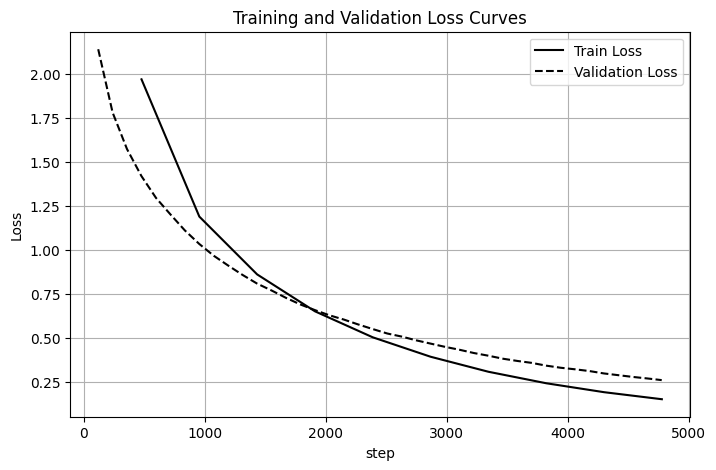

In [ ]:
# ---- Plot Loss Results ----
def get_loss_from_events(logdir, tag):
    ea = event_accumulator.EventAccumulator(logdir)
    ea.Reload()
    events = ea.Scalars(tag)
    steps = [x.step for x in events]
    values = [x.value for x in events]
    return steps, values

logdir = os.path.join("lightning_logs", "alignment", "version_1")  # Adjust version as needed
train_steps, train_loss = get_loss_from_events(logdir, "train_loss")
val_steps, val_loss = get_loss_from_events(logdir, "val_loss")

plt.figure(figsize=(8, 5))
plt.plot(train_steps, train_loss, '-',
         label="Train Loss", color='black')
plt.plot(val_steps, val_loss, '--',
         label="Validation Loss", color='black')
plt.xlabel("step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.show()

## Αποθήκευση του Μοντέλου

Μετά την ολοκλήρωση της εκπαίδευσης, μπορείτε να αποθηκεύσετε το εκπαιδευμένο μοντέλο για μελλοντική χρήση ή επαναφόρτωση.

Παράδειγμα:

```python
# Save model checkpoint
ckpt_path = "alignment_model.ckpt"
trainer.save_checkpoint(ckpt_path)
print(f"Model saved to {ckpt_path}")
```

Μπορείτε να φορτώσετε το μοντέλο αργότερα με:

```python
# Load model checkpoint
lit_model = AlignmentLitModule.load_from_checkpoint(ckpt_path)
```

In [ ]:
# Checkpoint directory
ckpt_dir = "/mnt/h/output/checkpoints"
# Make sure directory exists
os.makedirs(ckpt_dir, exist_ok=True)
# Save the final model checkpoint
trainer.save_checkpoint(os.path.join(ckpt_dir, "cnn_alignment_model.ckpt"))
# Print statement
print(f"Model checkpoint saved to {ckpt_dir}/cnn_alignment_model.ckpt")

`weights_only` was not set, defaulting to `False`.


Model checkpoint saved to /mnt/h/output/checkpoints/cnn_alignment_model.ckpt
